# Dask Array (2)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Dask"
* https://docs.dask.org/en/latest/array.html
* https://gregorygundersen.com/blog/2018/12/10/svd/
* https://en.wikipedia.org/wiki/Cosine_similarity
* https://en.wikipedia.org/wiki/Adjacency_matrix
* https://en.wikipedia.org/wiki/Pairing_function#Cantor_pairing_function
* https://image.dask.org/en/latest/
* https://www.youtube.com/watch?v=-AuwMJAqjJc

## Задачи для совместного разбора

1. Создайте матрицу 100_000x1000 случайных чисел из нормального распределения. Получите SVD-разложение матрицы. Проверьте, что векторы $u_j, j>1$ ортогональны $u_0$. Вычислите длины левых сингулярных векторов.

2. Сгенерируйте вектор `a` размера 10, заполненный числами из нормального распределения. Пусть `b := -a`. Вычислите косинусное сходство двух этих векторов. Вычислите косинусное сходство каждой пары правых сингулярных векторов из задачи 1.

$$\text{similarity} = \cos(\theta) = {A \cdot B \over \|A\| \|B\|} = \frac{ \sum\limits_{i=1}^{n}{A_i \times B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{(A_i)^2}} \times \sqrt{\sum\limits_{i=1}^{n}{(B_i)^2}} }$$

3\. Загрузите изображения из каталога `imgs` при помощи пакета `dask_image`. Визуализируйте одно изображение в цвете и в оттенках серого. Отразите изображение по горизонтали. Визуализируйте исходный и преобразованных вариант на одном рисунке

In [ ]:
!pip install dask-image

In [ ]:
reflection_matrix = np.array([[1, 0, 0],
                              [0, -1, image.shape[1]-1],
                              [0, 0, 1]])

## Лабораторная работа 8

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений (расчет средних значений, расчет косинусной близости и т.д.) проводятся над `dask.array` и средствами пакета `dask` (и `dask_image`), если в задании не сказано обратного. Переход от `dask.array` к `numpy.array` или `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.array` (то есть то, что было получено до вызова `compute`, а не после).

In [1]:
import dask.array as da
import h5py
#import numpy as np
#import pandas as pd
import dask

<p class="task" id="1"></p>

1\. Сингулярным разложением (SVD) матрицы $A$ размера $M\times N$ называется разложение вида $A = USV^\top$, где $U$ - матрица размера $M\times N$  ортонормированных собственных векторов произведения $AA^\top$, $V^T$ - транспонированная матрица размера $N\times N$ ортонормированных собственных  векторов произведения $A^\top A$, $S$ - диагональная матрица сингулярных значений размера $N\times N$.

SVD может быть использовано для понижения размерности векторов. Для этого от матрицы $U$ оставляют первые $k$ столбцов $U_{\cdot,:k}$, от матрицы $S$ оставляют левый верхний квадрат размера $k\times k$ $S_{:k,:k}$ и вычисляется произведение $\hat{A} = U_{\cdot,:k}S_{:k,:k}$

Выберите эмбеддинги тех рецептов, которые относятся к группе с номеров 3 (файл `recipe_embeddings.h5`), и уменьшите их размерность до 64 при помощи реализации алгоритма SVD из пакета `dask.array.linalg`. Выведите количество строк и столбцов полученного массива.

Примечание: после отбора рецепта, принадлежащих третьей группе, вызовите у полученного массива метод `compute_chunk_sizes`, чтобы `dask` обновил метаинформацию в этом массиве. 

In [2]:
f1 = h5py.File("recipe_embeddings.h5", "r")
emb = da.from_array(f1['embeddings'])
mask = da.from_array(f1['mask'])
display(emb, mask)

dask.array<array, shape=(1200000, 312), dtype=float32, chunksize=(107546, 312), chunktype=numpy.ndarray>

dask.array<array, shape=(1200000,), dtype=int64, chunksize=(1200000,), chunktype=numpy.ndarray>

In [3]:
emb_3 = emb[mask==3].compute_chunk_sizes()
emb_3

dask.array<getitem_variadic, shape=(10000, 312), dtype=float32, chunksize=(921, 312), chunktype=numpy.ndarray>

In [4]:
U, s, Vh = da.linalg.svd(emb_3)
k = 64
U_64 = U[:,:k]
s_64 = da.diag(s[:k])

A_hat = U_64@s_64
A_hat

dask.array<getitem, shape=(10000, 64), dtype=float32, chunksize=(921, 64), chunktype=numpy.ndarray>

In [5]:
A_hat.shape

(10000, 64)

<p class="task" id="2"></p>

2\. Используя эмбеддинги уменьшенной размерности, полученные в задании 1, посчитайте косинусное сходство между каждой парой рецептов третьей группы. Выведите матрицу косинусного сходства на экран.

In [6]:
da.sum(da.linalg.norm(A_hat, axis=1)==1).compute()

0

In [7]:
dist_A = da.linalg.norm(A_hat,axis=1)
cos_m1 = (A_hat@A_hat.T) / (dist_A*dist_A.reshape(-1,1))
cos_m1.compute()

C:\Users\Alex\anaconda3\lib\site-packages\dask\array\routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 12
  out = blockwise(
C:\Users\Alex\anaconda3\lib\site-packages\dask\array\core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


array([[0.99999983, 0.77996181, 0.70962773, ..., 0.78566264, 0.72498296,
        0.70748967],
       [0.77996181, 1.        , 0.6422385 , ..., 0.86709919, 0.61588712,
        0.65344273],
       [0.70962773, 0.6422385 , 1.00000011, ..., 0.64595642, 0.87130874,
        0.87150228],
       ...,
       [0.7856627 , 0.86709925, 0.64595636, ..., 0.99999998, 0.64296745,
        0.66372928],
       [0.72498296, 0.61588712, 0.87130874, ..., 0.64296745, 0.99999972,
        0.91261616],
       [0.70748967, 0.65344273, 0.87150228, ..., 0.66372928, 0.91261616,
        1.00000014]])

In [8]:
dist_A = da.linalg.norm(A_hat,axis=1)
A_hat_norm = (A_hat.T/dist_A).T
cos_m2 = A_hat_norm@A_hat_norm.T
cos_m2.compute()

C:\Users\Alex\anaconda3\lib\site-packages\dask\array\routines.py:443: PerformanceWarning: Increasing number of chunks by factor of 12
  out = blockwise(


array([[1.        , 0.77996178, 0.70962795, ..., 0.78566265, 0.72498321,
        0.70748973],
       [0.77996178, 1.        , 0.64223861, ..., 0.86709918, 0.61588696,
        0.65344282],
       [0.70962795, 0.64223861, 1.        , ..., 0.64595626, 0.87130854,
        0.87150262],
       ...,
       [0.78566265, 0.86709918, 0.64595626, ..., 1.        , 0.64296768,
        0.66372944],
       [0.72498321, 0.61588696, 0.87130854, ..., 0.64296768, 1.        ,
        0.91261626],
       [0.70748973, 0.65344282, 0.87150262, ..., 0.66372944, 0.91261626,
        1.        ]])

<p class="task" id="3"></p>

3\. Используя результат задания 2, посчитайте и выведите на экран количество рецептов, для которых рецепт с индексом `242` входит число топ-5 ближайших рецептов в смысле косинусной близости. При поиске топ-5 рецептов для конкретного рецепта считайте, что он сам в это число не входит.

In [9]:
if_in = da.isin(cos_m2.argtopk(6, axis=1), test_elements=242)
count_if_in = da.any(if_in, axis=1).sum() - 1
count_if_in.compute()

8

<p class="task" id="4"></p>

4\. Графом называется совокупность двух множеств $G=(V,E)$: множества $V=\{v_1, ..., v_M\}$ узлов и множества ребер $E=\{(v_i, v_j)|v_i\in V, v_j\in V\}$, соединяющих эти узлы. Матрицей смежности невзвешенного графа называется квадратная матрица $A=[a_{ij}]$, в которой ${a_{ij}}$ обозначает количество ребер, соединяющих вершины $i$ и $j$.

Постройте матрицу смежности для графа рецептов на основе матрицы косинусного сходства между каждой парой рецептов. Будем считать, что между двумя рецептами в этом графе существует ребро, если косинусное сходство между двумя этими рецептами не менее 0.85. Петли (ребра из вершины в саму в себя) в графе должны отсутствовать. Посчитайте и выведите на экран количество ребер в данном графе. Проверьте, является ли полученная матрица смежности симметричной.

Примечание: считайте, что два различных рецепта не могут иметь косинусное сходство, равное 1.

In [14]:
adj_m = (cos_m2>=0.85) - da.eye(cos_m2.shape[0])
adj_m.compute()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [15]:
adj_m.sum().compute()

23832774.0

In [16]:
((cos_m2>=0.85).sum() - cos_m2.shape[0]).compute()

23832774

In [17]:
da.all(adj_m == adj_m.T).compute() # симметричная

True

<p class="task" id="5"></p>

5\. В файле `authors_info.hdf5` хранятся два датасета, содержащие информацию возрасте человека и количестве рецептов, оставленных этим человеком. Построите тепловую карту, где по горизонтальной оси откладываются значения количества рецептов, по вертикальной оси - значения количества лет, а на пересечении строк и столбцов указано количество раз, когда человек данного возраста оставил данное кол-во рецептов.

Подсказка: для подсчета количества каждой пары вы можете использовать функцию `da.bincount`. Эта функция не может работать с двумерными массивами, но вы можете закодировать каждую пару уникальным целым числом, например при помощи [этой функции](https://en.wikipedia.org/wiki/Pairing_function#Cantor_pairing_function).

In [18]:
f5 = h5py.File("authors_info.hdf5", "r")
f5.keys()

<KeysViewHDF5 ['age', 'num_recipes']>

In [19]:
ages, numbers = da.from_array(f5['age']), da.from_array(f5['num_recipes'])
display(ages, numbers)

dask.array<array, shape=(100000000,), dtype=int32, chunksize=(33554432,), chunktype=numpy.ndarray>

dask.array<array, shape=(100000000,), dtype=int32, chunksize=(33554432,), chunktype=numpy.ndarray>

$$\pi(k_1,k_2) := \frac{1}{2}(k_1+k_2)(k_1+k_2+1) + k_2$$

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
encoded = (1/2 * (ages+numbers) * (ages+numbers+1) + numbers).astype(int)
bn_cnt = da.bincount(encoded).compute_chunk_sizes()

In [22]:
y33, x33 = da.meshgrid(da.arange(80), da.arange(76,-1,-1))
mat_hm = (1/2 * (y33+x33) * (y33+x33+1) + y33).astype(int)
mat_hm.compute()

array([[ 2926,  3004,  3083, ..., 11858, 12013, 12169],
       [ 2850,  2927,  3005, ..., 11705, 11859, 12014],
       [ 2775,  2851,  2928, ..., 11553, 11706, 11860],
       ...,
       [    3,     7,    12, ...,  3237,  3318,  3400],
       [    1,     4,     8, ...,  3158,  3238,  3319],
       [    0,     2,     5, ...,  3080,  3159,  3239]])

In [23]:
bn_cnt_expend = da.pad(bn_cnt, (0, mat_hm.max().compute()-len(bn_cnt)+1), 'constant', constant_values=0)
da.compute(len(bn_cnt_expend), bn_cnt_expend)

(12170, array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [24]:
res = bn_cnt_expend[mat_hm.ravel()].reshape(77,80)
da.compute(res, res.shape)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 (77, 80))

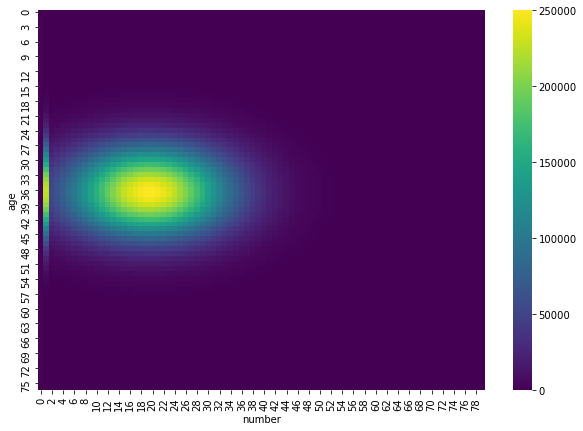

In [25]:
plt.figure(figsize=(10,7))
sns.heatmap(res, cmap='viridis')
plt.xlabel('number')
plt.ylabel('age')
plt.show()

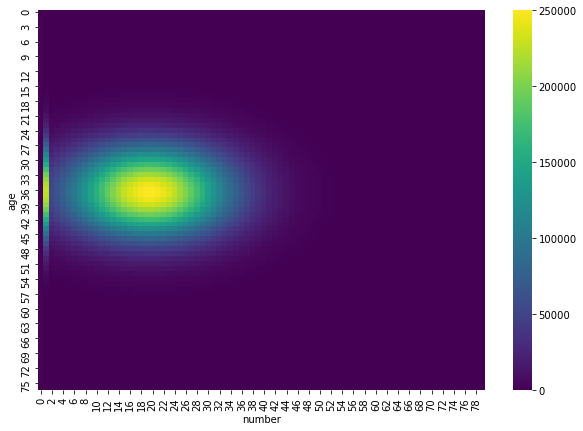

In [26]:
y33, x33 = da.meshgrid(da.arange(80), da.arange(76,-1,-1))

mat_hm = (1/2 * (y33+x33) * (y33+x33+1) + y33).astype(int)

bn_cnt_expend = da.pad(bn_cnt, (0, mat_hm.max().compute()-len(bn_cnt)+1), 'constant', constant_values=0)

res = bn_cnt_expend[mat_hm.ravel()].reshape(77,80)

plt.figure(figsize=(10,7))
sns.heatmap(res, cmap='viridis')
plt.xlabel('number')
plt.ylabel('age')
plt.show()

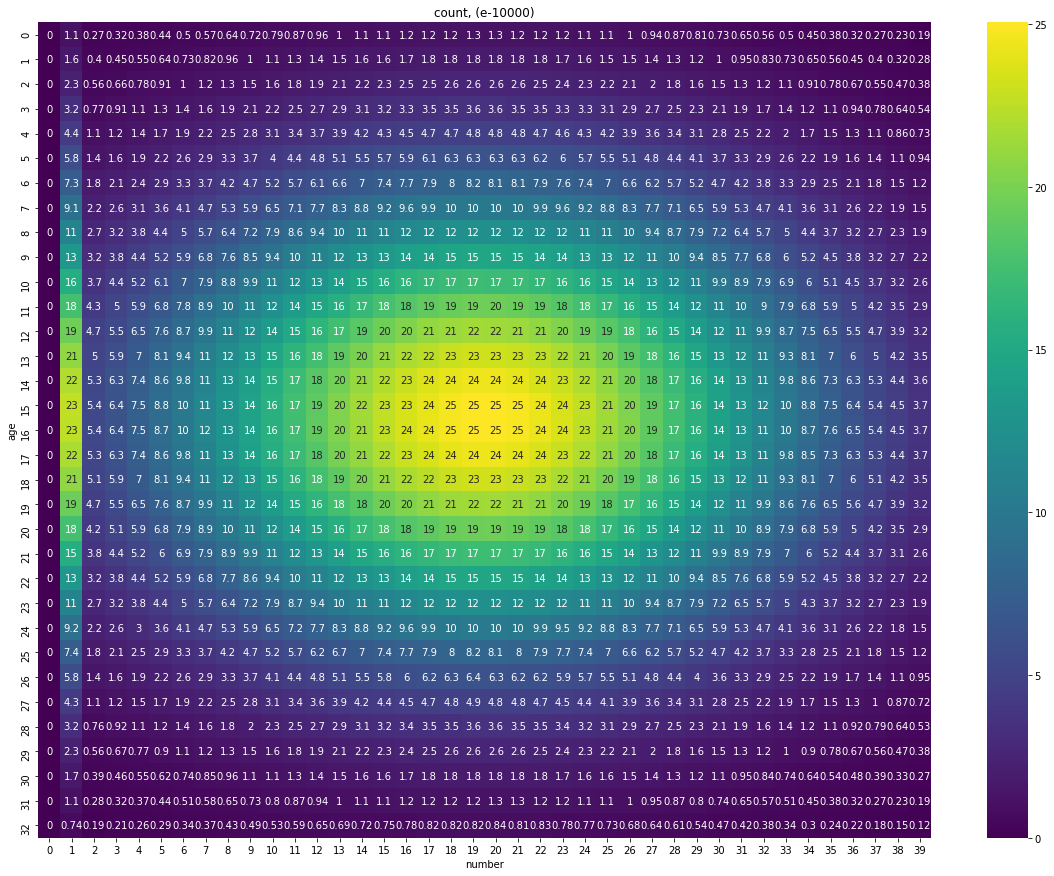

In [45]:
plt.figure(figsize=(20,15))
sns.heatmap(res[21:54,:40]/10000, cmap='viridis', annot=True)
plt.title('count, (e-10000)')
plt.xlabel('number')
plt.ylabel('age')
plt.show()

In [91]:
#zt = da.arange(bn_cnt.shape[0])
#wt = da.floor((np.sqrt(zt*8+1)-1)/2)
#tt = (wt**2+wt)//2
#xt = (zt - tt).astype(int)
#yt = (wt - xt).astype(int)
#
#for_heat = np.zeros([131,130])
#for_heat[yt,xt] = bn_cnt
#for_heat = da.from_array(for_heat)
#
#plt.figure(figsize=(10,7))
#plt.imshow(for_heat, cmap='viridis', interpolation='nearest')
#plt.colorbar()
#plt.xlabel('number')
#plt.ylabel('age')
#plt.show()

<p class="task" id="6"></p>

6\. В архиве `food` находятся фотографии блюд. Удалите все изображения кроме тех, которые имеют размер 512x512. Загрузите изображения в виде массива `dask.array` при помощи пакета `dask_image`. Выведите на экран основную информацию о полученном массиве. Вычислите среднюю интенсивность трех цветов для каждого пикселя каждого изображения. Полученный трехмерный массив далее интерпретируйте как черно-белые изображения. Визуализируйте одно полученное изображение в черно-белой палитре.

In [92]:
#!pip install dask-image

In [93]:
import os
from PIL import Image

img_dir = r".\food"
for foldername in os.listdir(img_dir):
    for filename in os.listdir(img_dir+'\\'+foldername):
        #print(filename)
        filepath = os.path.join(img_dir, foldername, filename)
        with Image.open(filepath) as im:
            x, y = im.size

        if x!=512 or y!=512:
            #print(x,y)
            os.remove(filepath)

In [94]:
import dask_image
from dask_image.imread import imread

In [95]:
imgs = imread("./food/*/*.jpg")
imgs

dask.array<_map_read_frame, shape=(1735, 512, 512, 3), dtype=uint8, chunksize=(1, 512, 512, 3), chunktype=numpy.ndarray>

In [96]:
imgs2 = imgs.mean(axis=3)
imgs2

dask.array<mean_agg-aggregate, shape=(1735, 512, 512), dtype=float64, chunksize=(1, 512, 512), chunktype=numpy.ndarray>

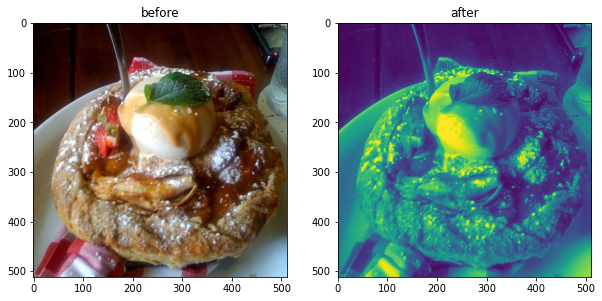

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(imgs[0])
ax1.set_title('before')
ax2.imshow(imgs2[0])
ax2.set_title('after')
plt.show()

<p class="task" id="7"></p>

7\. Добавьте на изображения шум. Для этого сгенерируйте массив, состоящий из нулей и единиц, в котором доля нулей составляет 15%. Выведите на экран среднее значение сгенерированного массива.

Поэлементно умножьте этот массив на каждое черно-белое изображение. На одном рисунке визуализируйте изображение до и после добавления шума. Постройте гистограммы интенсивности пикселей до и после добавления шума.

In [101]:
noise = da.random.choice([0, 1], size=(512,512), p=[0.15, 0.85])
noise.mean().compute()

0.8501014709472656

In [102]:
imgs7 = imgs2*noise

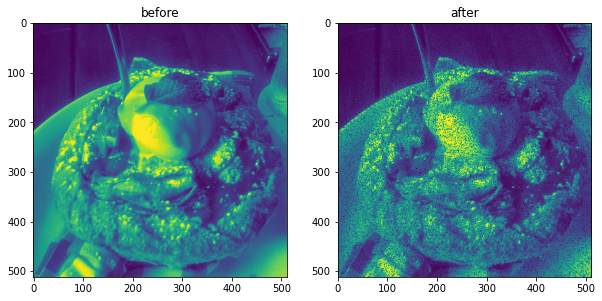

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(imgs2[0])
ax1.set_title('before')
ax2.imshow(imgs7[0])
ax2.set_title('after')
plt.show()

<p class="task" id="8"></p>

8\. Примените фильтр Гаусса из пакета `dask_image.ndfilters` к черно-белым изображениям. На одном рисунке визуализируйте изображение до и после применения фильтра. Исследуйте, как влияют значения `sigma` и `truncate` на результат. Проверьте не менее трех комбинаций этих параметров.

In [104]:
from dask_image.ndfilters import gaussian_filter

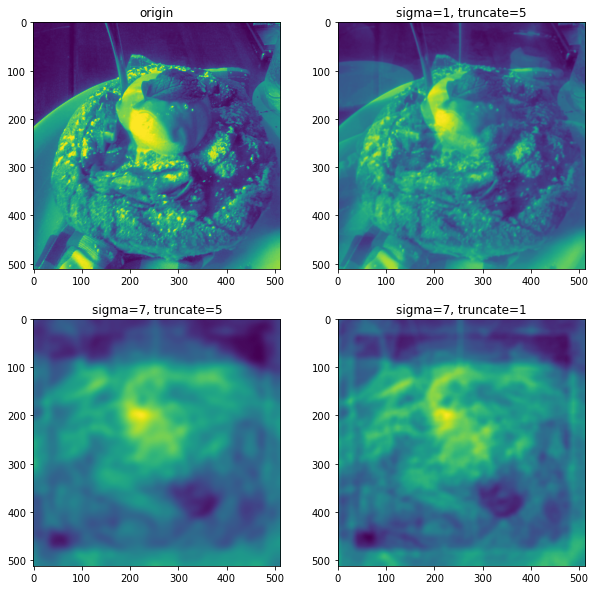

In [105]:
imgs8_1 = gaussian_filter(imgs2, sigma=1, truncate=5)
imgs8_2 = gaussian_filter(imgs2, sigma=7, truncate=5)
imgs8_3 = gaussian_filter(imgs2, sigma=7, truncate=1)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes[0,0].imshow(imgs2[0])
axes[0,0].set_title('origin')
axes[0,1].imshow(imgs8_1[0])
axes[0,1].set_title('sigma=1, truncate=5')
axes[1,0].imshow(imgs8_2[0])
axes[1,0].set_title('sigma=7, truncate=5')
axes[1,1].imshow(imgs8_3[0])
axes[1,1].set_title('sigma=7, truncate=1')
plt.show()